<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting_v1/blob/main/sector_indices_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

gen_output = 0

Run date time (IST): 2024-11-01 13:44:33


In [ ]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=e963efb0a4bebcb6cb7a0c98d9555b8727e1211769b698e8be6743ae3c0038e6
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [ ]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
import pandas_ta as ta

from google.colab import data_table

In [ ]:
# set start and end date
start_date = (datetime.date.today() + datetime.timedelta(days=-366)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=-1)).strftime('%Y-%m-%d')

In [ ]:
# fetch nse indices scrips

import pandas as pd
import numpy as np

df_nse_sectors = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/NSE_Sectors_Indices.csv')

In [ ]:
sectors = df_nse_sectors['Sector'].unique()
#print(sectors)
#sectors = ['BANKS', 'IT']
df_sectors = pd.DataFrame()
for sector in sectors:
  stocks = df_nse_sectors[df_nse_sectors['Sector'] == sector]['Symbol'].values
  df_sector = pd.DataFrame()
  tweight = 0
  for stock in stocks:
    stock_df = yfin.Ticker(stock+'.NS').history(period='max', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    col = ['Close']
    stock_df = stock_df[col]
    stock_df['Split'] = 1
    weight = df_nse_sectors[df_nse_sectors['Symbol'] == stock]['Weight'].values[0]
    tweight = sum(df_nse_sectors[df_nse_sectors['Sector'] == sector]['Weight'].values)
    if stock == 'NESTLEIND':
      stock_df.loc[stock_df.index < '2024-01-01', 'Split'] = 10
    #stock_df[stock] = (stock_df[col]*weight)/(tweight*stock_df['Split'].values[0])
    stock_df[stock] = stock_df['Close']/stock_df['Split']
    col = [stock]
    stock_df = stock_df[col]
    df_sector = pd.concat([df_sector, stock_df], axis=1)

  df_sector[sector] = df_sector[stocks].sum(axis=1)
  col = [sector]
  df_sector = df_sector[col]
  df_sectors = pd.concat([df_sectors, df_sector], axis=1)
sector_df_full = df_sectors

In [ ]:
def stock_prec_dev(stock_symbol):
    #print(stock_symbol)
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))

    stock_df = df_sectors[[stock_symbol]]
    stock_df.columns = ['Close']

    #stock_df['Max'] = round(max(stock_df['Close']),2)
    stock_df['Max']  = round(stock_df['Close'].dropna().max(), 2)
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    stock_df['Sector'] = stock_symbol

    stock_df['Close'] = round(stock_df['Close'],2)

    #stock_df['Min'] = round(min(stock_df['Close']),2)
    stock_df['Min']  = round(stock_df['Close'].dropna().min(), 2)
    #stock_df['Gained%'] = round((stock_df['Close'] - stock_df['Min'])*100/stock_df['Min'],2)
    stock_df.ta.rsi(append=True)
    #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
    #stock_df['Close'] = round(stock_df['Close'],0)
    stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
    stock_df['ATH%'] = round((stock_df['Max'] - stock_df['Close'])*100/stock_df['Close'],2)
    #stock_df['Sector'] = stock_symbol
    stock_df = stock_df.tail(1)
    return stock_df

In [ ]:
df_final =  pd.DataFrame()
for sector in sectors:

  df_tmp = stock_prec_dev(sector)
  df_final = pd.concat([df_final, df_tmp], ignore_index = True) #df_final.append(df_tmp)
# all sectors
df_final = df_final.sort_values(by = 'ATH%', ascending=False)
#data_table.DataTable(df_final, include_index=False)
df_final

,Close,Max,200_SMA,Dev%_200,Sector,Min,RSI_14,ATH%
13,6179.51,7751.67,6175.0,0.07,TEXTILES,5348.15,50.0,25.44
0,31993.55,39245.70,32210.0,-0.67,AUTO,22078.35,27.0,22.67
14,4247.10,4911.95,4277.0,-0.70,FOOTWEAR,3911.23,44.0,15.65
12,4485.15,5186.65,4682.0,-4.20,JEWELLERY,4150.52,33.0,15.64
4,12612.05,14401.55,12584.0,0.22,FMCG,8686.13,32.0,14.19
7,6127.83,6904.04,6083.0,0.74,METAL,4291.89,45.0,12.67
2,10100.60,11336.71,10082.0,0.18,FINANCE,9171.23,44.0,12.24
10,40868.25,45422.43,41597.0,-1.75,CEMENT,37963.88,47.0,11.14
15,1919.78,2125.54,1623.0,18.29,SUGAR,1276.49,48.0,10.72
6,3475.66,3825.14,3220.0,7.94,MEDIA,1884.91,51.0,10.06


<Axes: xlabel='Date'>

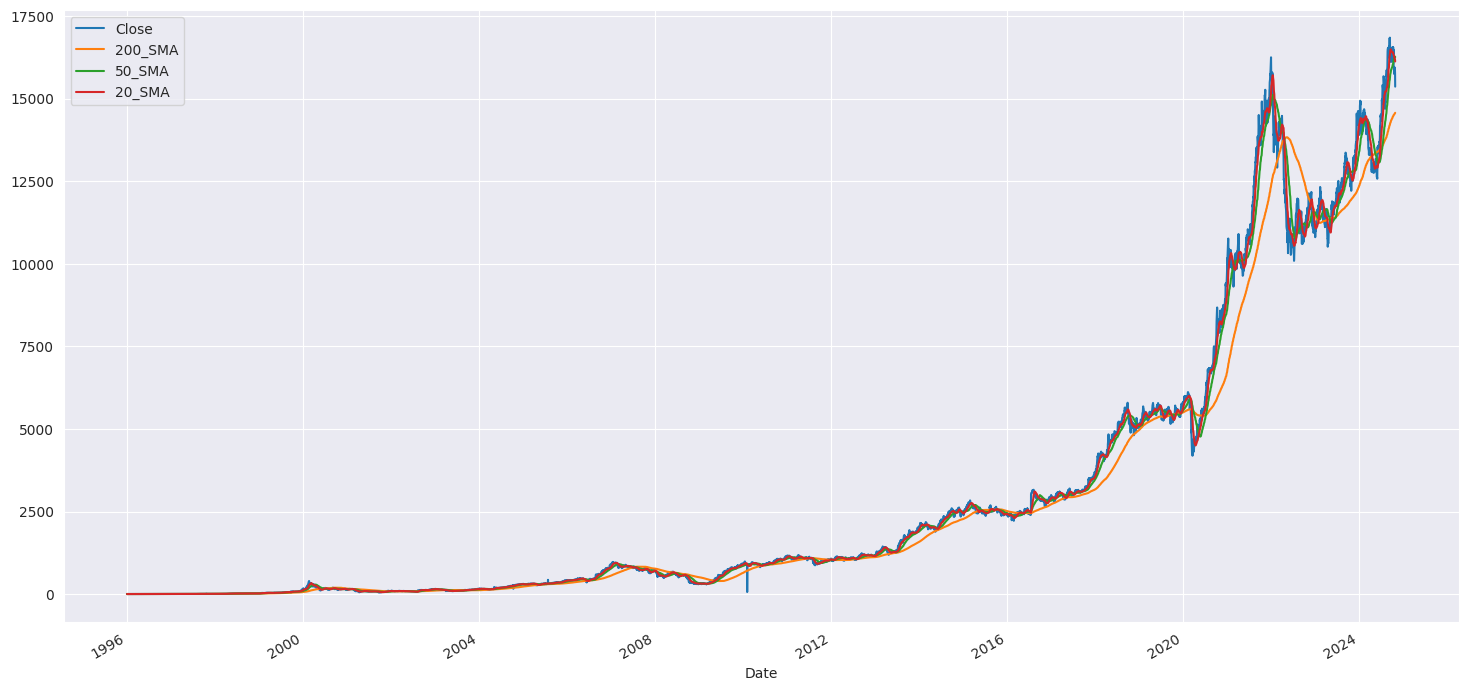

In [ ]:
col = ['IT']
sector_df = sector_df_full[col]
sector_df.columns = ['Close']
sector_df['200_SMA'] = round(sector_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
sector_df['50_SMA'] = round(sector_df['Close'].rolling(window = 50, min_periods = 1).mean(),0)
sector_df['20_SMA'] = round(sector_df['Close'].rolling(window = 20, min_periods = 1).mean(),0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = sector_df.reset_index()
tmp_df.plot(x='Date', y=['Close','200_SMA','50_SMA','20_SMA'], figsize=(18,9))

In [ ]:
df_sectors = df_sectors[(df_sectors.index <= end_date) & (df_sectors.index >= start_date)]
for sector in sectors:
  base_value = df_sectors[sector].head(1).values[0]
  df_sectors[sector] = df_sectors[sector]*100/base_value

df_sectors

,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES,FOOTWEAR,SUGAR
Date,,,,,,,,,,,,,,,,
2023-11-01 00:00:00+05:30,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2023-11-02 00:00:00+05:30,100.194152,100.678999,100.138175,100.693001,102.038185,100.570376,100.351438,100.674926,101.172261,101.937106,101.541087,101.324354,100.857555,101.450871,100.729408,102.195542
2023-11-03 00:00:00+05:30,100.641589,101.178652,99.416447,101.782079,102.590469,101.012760,100.921220,101.558768,102.978999,102.357785,101.862061,102.697060,102.712753,102.376899,101.908398,102.555158
2023-11-06 00:00:00+05:30,101.346182,101.996524,101.214142,102.359472,103.495310,103.045625,102.171914,102.918529,104.166195,103.805430,103.416306,104.250425,102.993510,102.577543,101.857758,104.208087
2023-11-07 00:00:00+05:30,101.032457,102.412007,100.661975,102.667391,104.071217,103.722389,102.917106,102.850604,104.144498,103.617865,104.239424,104.269925,103.544225,101.537636,101.317468,104.444855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25 00:00:00+05:30,148.186783,120.074724,102.122897,130.184882,144.191914,165.498197,96.858697,135.519927,137.520319,130.479221,106.717099,217.503995,103.447388,107.768659,94.038680,141.277253
2024-10-28 00:00:00+05:30,147.402761,120.120165,102.805977,130.544648,145.450242,165.851086,99.915238,139.713189,138.238646,129.845576,107.478873,219.679052,104.052716,107.063730,93.745014,143.487876
2024-10-29 00:00:00+05:30,143.675353,122.310308,104.870517,130.064697,144.734732,163.702539,100.296267,140.693647,138.895478,130.328651,108.377489,223.575092,104.311808,106.461032,93.837990,145.511197


In [ ]:
cols = df_sectors.columns
for col in cols:
  median = df_sectors.loc[df_sectors[col]< 90, col].median()
  df_sectors.loc[df_sectors[col] < 90, col] = np.nan
  df_sectors[col] = np.where(df_sectors[col] < 90, median,df_sectors[col])

<Axes: xlabel='Date'>

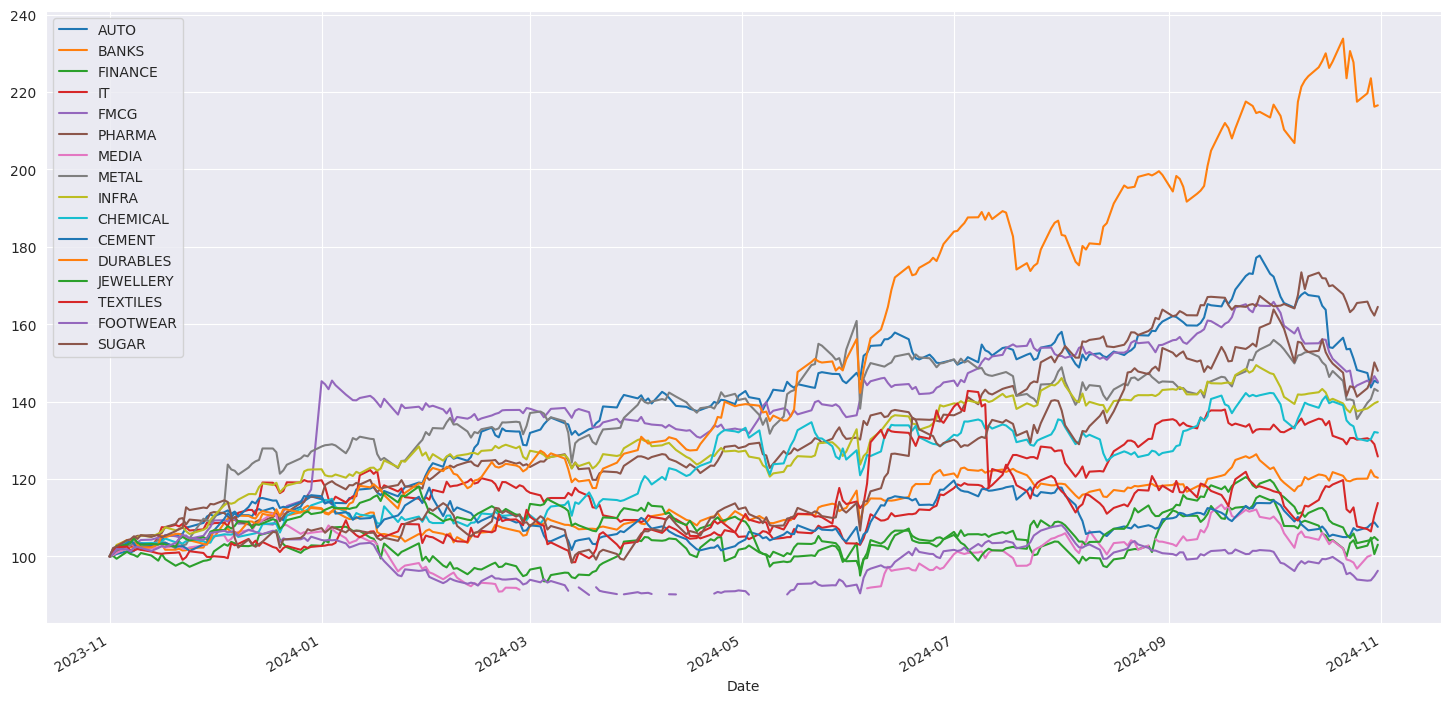

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = df_sectors.reset_index()
tmp_df.plot(x='Date', y=sectors, figsize=(18,9))

In [ ]:
df_tmp = df_sectors.tail(1).T
df_tmp.columns = ['Close']
df_tmp.sort_values(by = 'Close', ascending=False)

,Close
DURABLES,216.577190
PHARMA,164.496331
SUGAR,147.974643
FMCG,145.197540
AUTO,144.909140
METAL,142.777111
INFRA,139.996165
CHEMICAL,132.002057
IT,125.837223
BANKS,120.345598
